## Fine-tuning with chainer

In this example, we're going to fit the trained model to another dataset called 'fine tuning' or 'transfer learning'.  
Download the 'CaffeNet' model file and set the correct paths to these files.  
* caffemodel: https://github.com/BVLC/caffe/tree/master/models/bvlc_reference_caffenet  
* meanfile: https://github.com/BVLC/caffe/tree/master/python/caffe/imagenet 

In [1]:
path_to_model = 'caffenet/bvlc_reference_caffenet.caffemodel'
path_to_mean = 'caffenet/ilsvrc_2012_mean.npy'

We'll also use the OxFord Flowers 17 dataset.  
Download the dataset from the following URL, extract 'jpg' directory and set the correct path.   
* http://www.robots.ox.ac.uk/~vgg/data/bicos/

In [2]:
path_to_dataset = 'oxfordflower17/'

CaffeNet uses the mean subtracted images so that the prediction accuracy of the network improves. We should subtract the pre-computed mean value from every color channel before training.

In [3]:
import numpy as np
mean = np.load(path_to_mean).mean(1).mean(1)
print mean # BGR order

[ 104.00698793  116.66876762  122.67891434]


Take care that CaffeNet uses images which shape is 3x227x227, the each value ranges from 0 to 255, the mean subtracted and BGR order not RGB.

In [4]:
import skimage as ski
from skimage import io, transform
    
def improcess(path_to_im):
    im = ski.io.imread(path_to_im)
    im = ski.transform.resize(im, (227, 227))
    im = im.transpose(2, 0, 1) # in order (color, height, width)
    im *= 255
    im = im[[2, 1, 0], :, :] # RGB to BGR order
    im -= mean[:, np.newaxis, np.newaxis]
    return im.astype(np.float32)

def imdeprocess(data):
    im = data + mean[:, np.newaxis, np.newaxis]
    im = im[[2, 1, 0], :, :]
    im /= 255
    im = im.transpose(1, 2, 0)
    return im

Load the dataset and pre-process the images.  
The OxFord Flowers 17 dataset includes 80 images per category. Now we devided it in half (for training and test).

In [5]:
np.random.seed(777)
filenames = np.loadtxt(path_to_dataset + 'jpg/files.txt', dtype=str)
train_data = []
train_labels = []
test_data = []
test_labels = []

for i,filename in enumerate(filenames):
    im = improcess(path_to_dataset + 'jpg/' + filename)
    if i % 80 == 0: 
        perm = np.random.permutation(80)
    if perm[i % 80] < 40:
        train_data.append(im)
        train_labels.append(i // 80)
    else:
        test_data.append(im)
        test_labels.append(i // 80)

In [6]:
# shuffle the data for training
perm = np.random.permutation(len(train_data))
train_labels = np.array(train_labels).astype(np.int32)[perm]
train_data = np.array(train_data)[perm]

# shuffle the data for test
perm = np.random.permutation(len(test_data))
test_labels = np.array(test_labels).astype(np.int32)[perm]
test_data = np.array(test_data)[perm]

In [7]:
label_names = ['Daffodil', 'Snowdrop', 'Lily Valley', 'Bluebell',
               'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary',
               'Sunflower', 'Daisy', 'Colls\' Foot', 'Dandelion',
               'Cowslip', 'Buttercup', 'Windflower', 'Pansy']

Let's take a look at some data in the dataset.

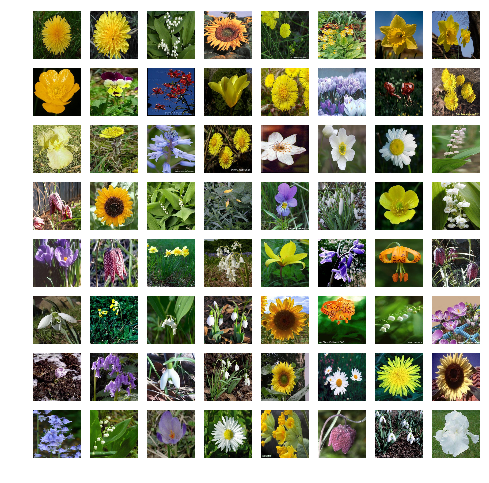

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]))

Import chainer and the dependencies.

In [9]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

If you use a gpu, set the gpu device value here.

In [10]:
gpu = 0 # gpu device ID (cpu if negative)
xp = cuda.cupy if gpu >= 0 else np

Import the CaffeNet model to chainer (may take a few minutes).  
Then save the model in the chainer format.

In [11]:
import chainer.functions.caffe
caffenet = chainer.functions.caffe.CaffeFunction(path_to_model)
chainer.serializers.save_hdf5('caffenet/caffenet.chainermodel', caffenet)

We'll get the same prediction as the following caffe tutorial.  
http://nbviewer.ipython.org/github/bvlc/caffe/blob/master/examples/00-classification.ipynb

Predicted class is #277.


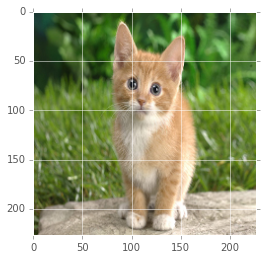

In [12]:
plt.imshow(imdeprocess(improcess('caffenet/cat.jpg')))
x = chainer.Variable(improcess('caffenet/cat.jpg')[np.newaxis,:])
fc8, = caffenet(inputs={'data': x}, outputs=['fc8'])
y = F.softmax(fc8)
print("Predicted class is #{}.".format(y.data.argmax()))

Finally, let's start fine-tuing.  
For further training of CaffeNet layers, redefine them and load weights from caffemodel.  
We need to describe the name and parameters of the layers correctly as the network difinition file of CaffeNet.  
* https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/deploy.prototxt

Then define the architecture of the network in "`def forward`".  
We modified LRN (local response normalization) layers, because LRN in caffe implementation is different from one in chainer. Here we set $k=n$ and multiply the LRN outputs by $n^\beta$.  
 
* Chainer  
$y_i=\displaystyle ¥rac{x_i}{(k+\alpha \sum_{j=max(0,i-n/2)}^{min(N-1,i+n/2)} x_j^2)^\beta}$  
* Caffe  
$y_i=\displaystyle \frac{x_i}{(1+\alpha/n \sum_{j=max(0,i-n/2)}^{min(N-1,i+n/2)} x_j^2)^\beta}$

In [13]:
class CNN(chainer.Chain):
    
    def __init__(self):
        self.caffe = chainer.Chain(
            conv1 = L.Convolution2D(3, 96, ksize=11, stride=4),
            conv2 = L.Convolution2D(96, 256, ksize=5, pad=2),
            conv3 = L.Convolution2D(256, 384, ksize=3, pad=1),
            conv4 = L.Convolution2D(384, 384, ksize=3, pad=1),
            conv5 = L.Convolution2D(384, 256, ksize=3, pad=1),
            fc6 = L.Linear(9216, 4096),
            fc7 = L.Linear(4096, 4096),
        )
        self.fine = chainer.Chain(
            fc8ft = F.Linear(4096, 17),
        )
        
    def __call__(self, x, t, train=True):
        y = self.forward(x, train=train)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss
    
    def forward(self, x, train=False):
        self.data = x
        self.conv1 = F.relu(self.caffe.conv1(self.data))
        self.pool1 = F.max_pooling_2d(self.conv1, ksize=3, stride=2)
        self.norm1 = F.local_response_normalization(self.pool1,
                            k=5, n=5, alpha=0.0001, beta=0.75)*np.power(5, 0.75)
        self.conv2 = F.relu(self.caffe.conv2(self.norm1))
        self.pool2 = F.max_pooling_2d(self.conv2, ksize=3, stride=2)
        self.norm2 = F.local_response_normalization(self.pool2,
                            k=5, n=5, alpha=0.0001, beta=0.75)*np.power(5, 0.75)
        self.conv3 = F.relu(self.caffe.conv3(self.norm2))
        self.conv4 = F.relu(self.caffe.conv4(self.conv3))
        self.conv5 = F.relu(self.caffe.conv5(self.conv4))
        self.pool5 = F.max_pooling_2d(self.conv5, ksize=3, stride=2)
        self.fc6 = F.dropout(F.relu(self.caffe.fc6(self.pool5)), train=train)
        self.fc7 = F.dropout(F.relu(self.caffe.fc7(self.fc6)), train=train)
        self.fc8 = self.fine.fc8ft(self.fc7)
        return self.fc8

In [14]:
model = CNN()
chainer.serializers.load_hdf5('caffenet/caffenet.chainermodel', model.caffe)

Set the optimizer. We should drop the learning rate in trained layers because they need less tuning than initialized layers. The learning rate of the CaffeNet have been already dropped by $10^{-4}$ after 450,000 iterations. We can train only the last layer is another way if you want to get the training converged faster.

In [15]:
opt_caffe = chainer.optimizers.Adam(alpha=1e-7) # default:1e-3
opt_caffe.setup(model.caffe)
opt_fine = chainer.optimizers.Adam()
opt_fine.setup(model.fine)
if gpu >= 0:
    cuda.get_device(gpu).use()
    model.caffe.to_gpu()
    model.fine.to_gpu()

Define a function to evalute the net.

In [16]:
import sys
import progressbar as prg
batchsize = 20

def test(x, y):
    sum_accuracy = 0
    sum_loss = 0
    with prg.ProgressBar(max_value=len(y)) as bar:
        for i in six.moves.range(0, len(y), batchsize):
            bar.update(i + batchsize)
            x_batch = chainer.Variable(
                xp.asarray(x[i:i + batchsize]), volatile='on')
            t_batch = chainer.Variable(
                xp.asarray(y[i:i + batchsize]), volatile='on')
            model(x_batch, t_batch, train=False)
            sum_loss += float(model.loss.data)
            sum_accuracy += float(model.accuracy.data)
    sys.stderr.flush()
    return sum_loss * batchsize / len(y), sum_accuracy * batchsize /len(y)

In [17]:
losses, test_its, test_losses, test_accs = ([] for i in range(4))
loss, acc = test(test_data, test_labels)
test_its.append(len(losses))
test_losses.append(loss)
test_accs.append(acc)
print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))

100% (680 of 680) |###########################| Elapsed Time: 0:00:03 Time: 3.66


test: loss=3.96211401855, accuracy=0.0367647064302


Train the model by forward and backward computations.

In [18]:
n_epoch = 10
N = len(train_labels)

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    perm = np.random.permutation(N)
    with prg.ProgressBar(max_value=N) as bar:
        for i in six.moves.range(0, N, batchsize):
            bar.update(i + batchsize)
            x = chainer.Variable(
                xp.asarray(train_data[perm[i:i + batchsize]]),  volatile='off')
            t = chainer.Variable(
                xp.asarray(train_labels[perm[i:i + batchsize]]),  volatile='off')
            opt_fine.zero_grads()
            opt_caffe.zero_grads()
            loss = model(x, t)
            loss.backward()
            opt_fine.update()
            opt_caffe.update()
            losses.append(float(model.loss.data))
    sys.stderr.flush()
    
    # evaluate
    loss, acc = test(test_data, test_labels)
    test_its.append(len(losses))
    test_losses.append(loss)
    test_accs.append(acc)
    print('train: batch={}, loss={}'.format(
        str(i / batchsize + 1), str(float(model.loss.data))))
    print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))
    sys.stdout.flush()
    
# save model
serializers.save_hdf5('cnn-finetuning-caffe.chainermodel', model.caffe)
serializers.save_hdf5('cnn-finetuning-fine.chainermodel', model.fine)

100% (680 of 680) |###########################| Elapsed Time: 0:00:03 Time: 3.15
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.63


('epoch', 1)
train: batch=34, loss=0.853676795959
test: loss=0.579313526697, accuracy=0.81029412501


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.51
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.63


('epoch', 2)
train: batch=34, loss=0.697447299957
test: loss=0.409299151972, accuracy=0.864705874639


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.49
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.63


('epoch', 3)
train: batch=34, loss=0.764268994331
test: loss=0.422383783823, accuracy=0.870588239502


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.45
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 4)
train: batch=34, loss=0.747007369995
test: loss=0.346355823471, accuracy=0.87647058508


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.42
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 5)
train: batch=34, loss=0.505565047264
test: loss=0.305248923271, accuracy=0.895588227931


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.41
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.60


('epoch', 6)
train: batch=34, loss=0.753593623638
test: loss=0.349291809889, accuracy=0.883823529762


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.40
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.60


('epoch', 7)
train: batch=34, loss=0.690278470516
test: loss=0.344670860426, accuracy=0.897058821776


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.41
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.61


('epoch', 8)
train: batch=34, loss=0.562937676907
test: loss=0.320894369362, accuracy=0.895588231437


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.42
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.60


('epoch', 9)
train: batch=34, loss=0.600968003273
test: loss=0.328697461306, accuracy=0.897058825282


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.42
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.60


('epoch', 10)
train: batch=34, loss=0.411761015654
test: loss=0.33992202443, accuracy=0.89558823319


Plot the losses and the accuracies.

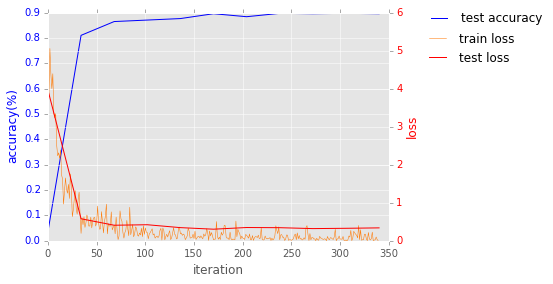

In [19]:
fig, ax1 = plt.subplots()
ax1.plot(test_its, test_accs, 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.48, 1.05), framealpha=0)
ax2 = ax1.twinx()
ax2.plot(range(len(losses)), losses, ls='-', lw=0.5, color='#ff7700')
ax2.plot(test_its, test_losses, 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.4, 0.96), framealpha=0)
plt.tight_layout()
plt.show()

Now we achieved 90% accuracy in the validation data after 10 epochs. Let's classify one of the data.

In [20]:
def predict(x, top=5):
    x = x.reshape(1, 3, 227, 227)
    x_batch = chainer.Variable(xp.asarray(x),  volatile='on')
    y_batch = F.softmax(model.forward(x_batch))
    results = list(zip(y_batch.data[0], label_names))
    results.sort(reverse=True)
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#{0:2d}| {1:12s} | {2:9.6f}%'.format(rank, name, float(score*100)))

label: Buttercup
# 1| Buttercup    | 94.995628%
# 2| Iris         |  3.462080%
# 3| Daffodil     |  1.258110%
# 4| Tigerlily    |  0.130635%
# 5| Cowslip      |  0.120529%


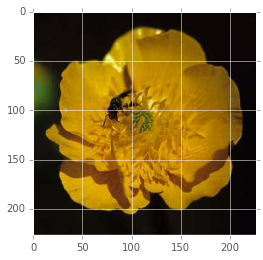

In [21]:
plt.imshow(imdeprocess(test_data[0]), interpolation='none')
print('label: ' + label_names[test_labels[0]])
predict(test_data[0])